# Obtaining and Organizing Dataset
The competition dataset is divided into a training set and a test set, which contain 50000 and 300000 images, respectively.

In the test set, 10000 images will be used for evaluation, while the remaining 290000 images will not be evaluated: they are included just to make it hard to cheat with manually labeled results of the test set.

The images in this dataset are all png color (RGB channels) image files, whose height and width are both 32 pixels.The images cover a total of 10 categories, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, boats, and trucks.

## Downloading the Dataset


In [1]:
from d2l import torch as d2l
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

##  Organizing the Dataset
We need to organize datasets to facilitate model training and testing

In [8]:
import os
def read_csv_labels(file_path):
    with open(file_path, 'r') as f:
        data = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in data]
    return dict(((name, label) for name, label in tokens))
file_path = os.path.join(data_dir, 'trainLabels.csv')
labels = read_csv_labels(file_path)
print('# training examples:', len(labels))
print('# classes:', len(set( labels.values() )))

# training examples: 1000
# classes: 10


In [13]:
data_dir

'../data\\kaggle_cifar10_tiny'

In [11]:
import pandas as pd
pd.read_csv(file_path)[:5]

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [12]:
def copy_file(file_name, target_dir):
    import shutil
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(file_name, target_dir)

 we define the reorg_train_valid function to split the validation set out of the original training set.


In [14]:
def reorg_train_valid(data_directory, labels_data, valid_ratio):
    from collections import Counter
    from math import floor
    """split the validation set out of the original training set"""
    # get class with least number of example in training set
    n = Counter(labels_data.values()).most_common()[-1][1]      # [-1]: the least common, [1]: Its number
    n_valid_per_labels = max(1, floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # train file look something like this: '437.png'
        label = labels[train_file.split('.')[0]]
        file_name = os.path.join(data_dir, 'train', train_file)
        target_dir = os.path.join(data_dir, 'train_valid_test', 'train_valid', label)
        copy_file(file_name, target_dir)

        if label not in label_count or label_count[label] < n_valid_per_labels:
            vali_target_dir = os.path.join(data_dir, 'train_valid_test', 'valid', label)
            copy_file(file_name, vali_target_dir)
            label_count[label] = label_count.get(label, 0) + 1
        else:
            train_target_dir = vali_target_dir = os.path.join(data_dir, 'train_valid_test', 'train', label)
            copy_file(file_name, train_target_dir)

    return n_valid_per_labels

In [17]:
#@save
def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction."""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copy_file(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [19]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [20]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## Image Augmentation

In [21]:
def image_augmentation():
    from torchvision import transforms
    from torchvision.transforms import Resize, RandomResizedCrop, ToTensor, Normalize, RandomHorizontalFlip
    train_aug = transforms.Compose([
        Resize(40),
            # Randomly crop a square image of 40 pixels in both height and width to
            # produce a small square of 0.64 to 1 times the area of the original
            # image, and then scale it to a square of 32 pixels in both height and
            # width
        RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    test_aug = transforms.Compose([
        ToTensor(),
        Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])
    return train_aug, test_aug

## Reading the Dataset

In [29]:
def create_folder_dataloader():
    from torchvision.datasets import ImageFolder
    train_aug, test_aug = image_augmentation()
    train_valid_test_dir = os.path.join(data_dir, 'train_valid_test')
    train_ds, train_val_ds = [ImageFolder(os.path.join(train_valid_test_dir, folder), transform=train_aug) for folder in ['train', 'train_valid']]
    val_ds, test_ds = [ImageFolder(os.path.join(train_valid_test_dir, folder), transform=test_aug) for folder in ['valid', 'test']]
    return train_ds, train_val_ds, val_ds, test_ds
train_ds, train_val_ds, val_ds, test_ds =    create_folder_dataloader()

In [30]:
def create_dataloader(train_ds, train_val_ds, val_ds, test_ds):
    from torch.utils.data import DataLoader
    train_iter, train_val_iter = [DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_val_ds)]
    valid_iter = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    test_iter = DataLoader(test_ds, batch_size, shuffle=True, drop_last=False)
    return train_iter, train_val_iter, valid_iter, test_iter

train_iter, train_val_iter, valid_iter, test_iter = create_dataloader(train_ds, train_val_ds, val_ds, test_ds)

In [31]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

In [32]:
from torch import nn
loss = nn.CrossEntropyLoss(reduction='none')

# Defining the Training Function

In [35]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    import torch
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches = len(train_iter)
    timer = d2l.Timer()
    legend = ['train_loss', 'train_acc']
    if valid_iter is not None:
        legend.append('val_acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=legend)

    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (train_features, train_labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, train_features, train_labels,
                                          loss,  optimizer, devices)
            metric.add(l, acc, train_labels.shape[0])
            timer.stop()

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[2], None))

        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))

        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
      f' examples/sec on {str(devices)}')

## Training and Validating the Model

train loss 0.594, train acc 0.796, valid acc 0.375
437.5 examples/sec on [device(type='cuda', index=0)]


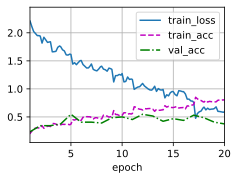

In [36]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Classifying the Testing Set and Submitting Results on Kaggle

train loss 0.629, train acc 0.783
564.6 examples/sec on [device(type='cuda', index=0)]


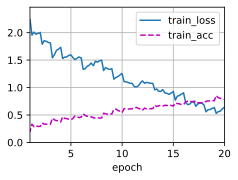

In [38]:
import torch
net, preds = get_net(), []
net(next(iter(train_val_iter))[0])
train(net, train_val_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_val_ds.classes[x])
df.to_csv('submission.csv', index=False)

#  Summary
1. We can read datasets containing raw image files after organizing them into the required format
2. We can use convolutional neural networks and image augmentation in an image classification competition.